In [7]:
import numpy as np
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import numpy as np
import fiona
from scipy.optimize import minimize_scalar


import time 

In [8]:
nuts_path = "in_data/admin/Forest_area_PL.geojson"

In [9]:
input_path = "out_data/predictions/poland_small_RFprobs_test.tif"

In [10]:
# Extract features (polygons) from the GeoJSON file using fiona
with fiona.open(nuts_path, "r") as geojson:
    features = [feature for feature in geojson]

In [11]:
features[0]['properties']['id']

'PL81'

In [12]:
# Function to compute the difference between vector forested area and raster forested area
def area_difference(threshold):
    classified_array = np.where(array >= threshold, 1, 0)
    raster_forested_area = np.sum(classified_array)   # Sum of '1' pixels times area per pixel
    return abs(raster_forested_area - admin_forest_area)  # Absolute difference in forested area


In [13]:
# here we just print the amout of data in a NUTS region

with rasterio.open(input_path) as src:
    for feature in features:
        geometry = feature["geometry"]
        
        # Mask and crop the raster using the current polygon
        out_image, out_transform = mask(src, [geometry], invert=False, crop=True)
        affine = out_transform
        array = out_image[1]
        profile = src.profile.copy() # copy the profile from the original raster
        
        print(array.shape)

(2246, 1885)
(1456, 1736)
(1272, 1497)


KeyboardInterrupt: 

In [47]:
start = time.time()
with rasterio.open(input_path) as src:
    for feature in features:
        geometry = feature["geometry"]
        
        # Mask and crop the raster using the current polygon
        out_image, out_transform = mask(src, [geometry], invert=False, crop=True)
        affine = out_transform
        array = out_image[1]
        profile = src.profile.copy() # copy the profile from the original raster
        
        # Update the profile with the dimensions of the cropped raster
        profile.update({
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })
        
        NUTS_id = feature['properties']['id']
        admin_forest_area = feature['properties']['X2018']
        print(f"NUTS id: {NUTS_id}------------------------")
        
        naive_area = sum(np.where(array >= 0.1, 1, 0).flatten())
        
        print(f"admin: {int(admin_forest_area)} ha. 0.5 Threshold: {naive_area}")
        
        
        # Find the threshold that minimizes the difference in forested area
        result = minimize_scalar(area_difference, bounds=(0, 1), method='bounded')

        # The optimal threshold
        optimal_threshold = result.x
        
        

        print(f"Optimal Threshold: {optimal_threshold}")

        
end = time.time()

print(f"Computation Time: {(end-start)} seconds")


NUTS id: PL81------------------------
admin: 768094 ha. 0.5 Threshold: 1067561
Optimal Threshold: 0.2862495522882775
NUTS id: PL21------------------------
admin: 362078 ha. 0.5 Threshold: 999005
Optimal Threshold: 0.8641173104913071
NUTS id: PL72------------------------
admin: 574655 ha. 0.5 Threshold: 651636
Optimal Threshold: 0.16327714539391655
NUTS id: PL84------------------------
admin: 667061 ha. 0.5 Threshold: 999437
Optimal Threshold: 0.4621545972708517
NUTS id: PL43------------------------
admin: 689518 ha. 0.5 Threshold: 936234
Optimal Threshold: 0.5706695266973594
NUTS id: PL22------------------------
admin: 625030 ha. 0.5 Threshold: 776777
Optimal Threshold: 0.22229874500953622
NUTS id: PL61------------------------
admin: 830702 ha. 0.5 Threshold: 687088
Optimal Threshold: 0.0332134474820044
NUTS id: PL63------------------------
admin: 250928 ha. 0.5 Threshold: 1003161
Optimal Threshold: 0.9832291729805938
NUTS id: PL71------------------------
admin: 332313 ha. 0.5 Threshol

In [46]:
out_image.shape

(2, 1353, 1190)

In [36]:
import matplotlib.pyplot as plt

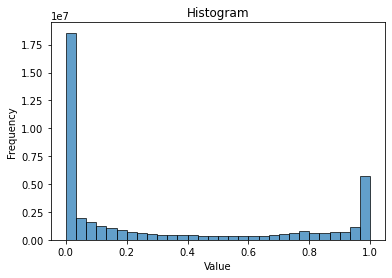

In [20]:
# Plot histogram
plt.hist(array.flatten(), bins=30, edgecolor='k', alpha=0.7)

# Add title and labels
plt.title('Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show plot
plt.show()

Optimal Threshold: 0.5524265600717729
Computation Time: 4.767550230026245 seconds


In [47]:
# Classify the raster with the optimal threshold
classified_array = np.where(array >= optimal_threshold, 1, 0)

In [48]:
sum(classified_array.flatten()) / (classified_array.shape[0]*classified_array.shape[1])

0.30009388790002595

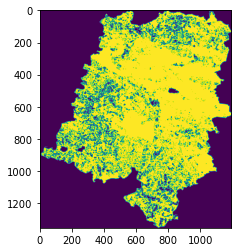

In [45]:
import matplotlib.colors as mcolors


# Create a colormap
colormap = plt.get_cmap('viridis')  # 'viridis' is one of the built-in colormaps, but many others are available

# Plot the heatmap
plt.imshow(classified_array, cmap=colormap)


Apply a blurr to the probability map to remove straggler pixels (single pixle forests)

In [50]:
from scipy.ndimage import gaussian_filter

In [51]:
array_blurr = gaussian_filter(array, sigma=1)

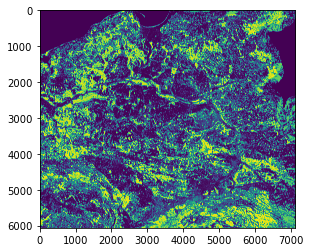

In [52]:
# Create a colormap
colormap = plt.get_cmap('viridis')  # 'viridis' is one of the built-in colormaps, but many others are available

# Plot the heatmap
plt.imshow(array, cmap=colormap)


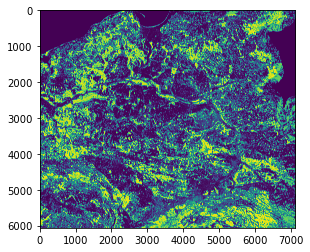

In [53]:
# Create a colormap
colormap = plt.get_cmap('viridis')  # 'viridis' is one of the built-in colormaps, but many others are available

# Plot the heatmap
plt.imshow(array_blurr, cmap=colormap)
